In [101]:
pip install plotly

  Using cached plotly-5.15.0-py2.py3-none-any.whl (15.5 MB)
  Using cached tenacity-8.2.2-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Initialize notebook environment.
%matplotlib inline
import boto3
import botocore
import os.path
import xarray as xr

from eosdis_store import EosdisStore
import requests
from pqdm.threads import pqdm
import pandas as pd
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML
import warnings
from pprint import pprint
import numpy as np
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import box, Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.patches import Polygon as mplPolygon
import matplotlib.ticker as mticker
import numpy as np
import shapely
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from shapely.ops import substring

/tmp/ipykernel_42/3813287903.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
era5_bucket = 'era5-pds'

# AWS access / secret keys required
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(era5_bucket)

# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

In [5]:
paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=era5_bucket, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

1979/
1980/
1981/
1982/
1983/
1984/
1985/
1986/
1987/
1988/
1989/
1990/
1991/
1992/
1993/
1994/
1995/
1996/
1997/
1998/
1999/
2000/
2001/
2002/
2003/
2004/
2005/
2006/
2007/
2008/
2009/
2010/
2011/
2012/
2013/
2014/
2015/
2016/
2017/
2018/
2019/
2020/
2021/
2022/
2023/
QA/
zarr/


In [6]:
keys = []
date = datetime.date(2020,6,1) # update to desired date
prefix = date.strftime('%Y/%m/')

response = client.list_objects_v2(Bucket=era5_bucket, Prefix=prefix)
response_meta = response.get('ResponseMetadata')

if response_meta.get('HTTPStatusCode') == 200:
    contents = response.get('Contents')
    if contents == None:
        print("No objects are available for %s" % date.strftime('%B, %Y'))
    else:
        for obj in contents:
            keys.append(obj.get('Key'))
        print("There are %s objects available for %s\n--" % (len(keys), date.strftime('%B, %Y')))
        for k in keys:
            print(k)
else:
    print("There was an error with your request.")

There are 20 objects available for June, 2020
--
2020/06/data/air_pressure_at_mean_sea_level.nc
2020/06/data/air_temperature_at_2_metres.nc
2020/06/data/air_temperature_at_2_metres_1hour_Maximum.nc
2020/06/data/air_temperature_at_2_metres_1hour_Minimum.nc
2020/06/data/dew_point_temperature_at_2_metres.nc
2020/06/data/eastward_wind_at_100_metres.nc
2020/06/data/eastward_wind_at_10_metres.nc
2020/06/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc
2020/06/data/lwe_thickness_of_surface_snow_amount.nc
2020/06/data/northward_wind_at_100_metres.nc
2020/06/data/northward_wind_at_10_metres.nc
2020/06/data/precipitation_amount_1hour_Accumulation.nc
2020/06/data/sea_surface_temperature.nc
2020/06/data/sea_surface_wave_from_direction.nc
2020/06/data/sea_surface_wave_mean_period.nc
2020/06/data/significant_height_of_wind_and_swell_waves.nc
2020/06/data/snow_density.nc
2020/06/data/surface_air_pressure.nc
2020/06/data/wind_speed_of_gust_at_10_metres_1

In [7]:
metadata_file = 'main.nc'
metadata_key = prefix + metadata_file
client.download_file(era5_bucket, metadata_key, metadata_file)
ds_meta = xr.open_dataset('main.nc', decode_times=False)
ds_meta.info()

xarray.Dataset {
dimensions:
	lon = 1440 ;
	lat = 721 ;
	time0 = 720 ;
	time1 = 720 ;
	lon_ocean = 720 ;
	lat_ocean = 361 ;
	nv = 2 ;

variables:
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 time0(time0) ;
		time0:units = seconds since 1970-01-01 ;
		time0:standard_name = time ;
	float64 time1(time1) ;
		time1:units = seconds since 1970-01-01 ;
		time1:standard_name = time ;
		time1:bounds = time1_bounds ;
	float32 lon_ocean(lon_ocean) ;
		lon_ocean:standard_name = longitude ;
		lon_ocean:long_name = longitude ;
		lon_ocean:units = degrees_east ;
	float32 lat_ocean(lat_ocean) ;
		lat_ocean:standard_name = latitude ;
		lat_ocean:long_name = latitude ;
		lat_ocean:units = degrees_north ;
	float32 snow_density(time0, lat, lon) ;
		snow_density:standard_name = snow_density ;
		snow_density:units = kg m**

In [8]:
# select date and variable of interest
date = datetime.date(2017,6,1)
var = 'sea_surface_temperature'

# file path patterns for remote S3 objects and corresponding local file
s3_data_ptrn = '{year}/{month}/data/{var}.nc'
data_file_ptrn = '{year}{month}_{var}.nc'

year = date.strftime('%Y')
month = date.strftime('%m')
s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
data_file = data_file_ptrn.format(year=year, month=month, var=var)

if not os.path.isfile(data_file): # check if file already exists
    print("Downloading %s from S3..." % s3_data_key)
    client.download_file(era5_bucket, s3_data_key, data_file)

ds = xr.open_dataset(data_file)
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                  (lon: 1440, lat: 721, time0: 720)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                    (time0) datetime64[ns] 2017-06-01 ... 2017-06-30...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts>

In [9]:
output_file = 'ERA5_2017_06_sst.nc'
ds.to_netcdf(output_file)

print("Dataset downloaded and saved to %s." % output_file)

Dataset downloaded and saved to ERA5_2017_06_sst.nc.


In [10]:
ds.sea_surface_temperature

<xarray.DataArray 'sea_surface_temperature' (time0: 720, lat: 721, lon: 1440)>
[747532800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time0    (time0) datetime64[ns] 2017-06-01 ... 2017-06-30T23:00:00
Attributes:
    standard_name:   sea_surface_temperature
    units:           K
    long_name:       Sea surface temperature
    nameECMWF:       Sea surface temperature
    shortNameECMWF:  sst
    nameCDM:         Sea_surface_temperature_surface
    product_type:    analysis

In [11]:
lons = np.arange(45, 90)
lats = np.arange(-5, 35)

In [12]:
month, days = "06", len(ds['time0']) // 24 # count the days in the month selected
df_raw = pd.DataFrame()

for i in range(1, days + 1):
    day_str = f"{i:02}"
    time = f"2017-{month}-{day_str}T9:00:00"
    sst = ds['sea_surface_temperature'].sel(lat=lats, lon=lons, time0=time)
    df_sst = sst.to_dataframe().reset_index()
    df_raw = pd.concat([df_raw, df_sst])

In [13]:
df_raw['time0'] = pd.to_datetime(df_raw['time0'])

# Extract the date from the 'time0' column
df_raw['date'] = df_raw['time0'].dt.date

# Group the data by day
grouped = df_raw.groupby('date')

/tmp/ipykernel_42/2408616899.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


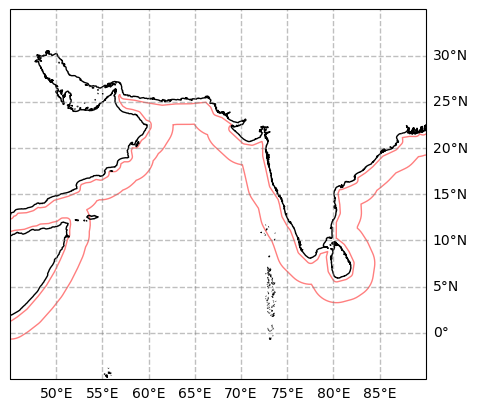

In [14]:
crs = ccrs.PlateCarree()

lats = slice(-5, 35)
lons = slice(45, 90)

coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define bounding box and convert to a GeoDataFrame
bbox = Polygon([(lons.start, lats.start), (lons.start, lats.stop), (lons.stop, lats.stop), (lons.stop, lats.start)])
bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
bbox_gdf.set_crs('EPSG:4326', inplace=True)

# Clip the coastline with the bounding box
coastline_clipped = gpd.clip(coastline, bbox_gdf)

# Convert the clipped coastline to UTM zone 43N
coastline_utm_clipped = coastline_clipped.to_crs('EPSG:32643')

distances = [50000, 300000]

# Create buffered geometries
buffered = []
for distance in distances:
    buffer = coastline_utm_clipped.buffer(distance)
    buffered.append(buffer)

# Convert buffered geometries to a GeoDataFrame, unify them, set CRS and transform to WGS84 CRS
buffered_gdfs = []
for b in buffered:
    unified = shapely.ops.unary_union(b)
    gdf = gpd.GeoDataFrame(gpd.GeoSeries(unified), columns=['geometry'])
    gdf.set_crs('EPSG:32643', inplace=True)  # Set the CRS to UTM zone 43N
    buffered_gdfs.append(gdf)

buffered_wgs84 = [gdf.to_crs('EPSG:4326') for gdf in buffered_gdfs]  # Convert to WGS84

# Unify all buffered geometries
union_buffered = unary_union(buffered)

# Plotting
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lons.start, lons.stop, lats.start, lats.stop], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(int(lons.start), int(lons.stop)+1, 5))   # Set longitude markers every 5 degrees
gl.ylocator = mticker.FixedLocator(range(int(lats.start), int(lats.stop)+1, 5))   # Set latitude markers every 5 degrees

# Plot buffers
for buf in buffered_wgs84:
    for geom in buf.geometry:
        if geom.is_empty:
            continue
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        for polygon in geom.geoms:
            x, y = polygon.exterior.coords.xy
            coords = np.column_stack((x, y))
            mpl_poly = mplPolygon(coords, edgecolor='red', facecolor='none', alpha=0.5)
            ax.add_patch(mpl_poly)

# Set the axes limits to your bounding box
ax.set_xlim([lons.start, lons.stop])
ax.set_ylim([lats.start, lats.stop])

plt.show()

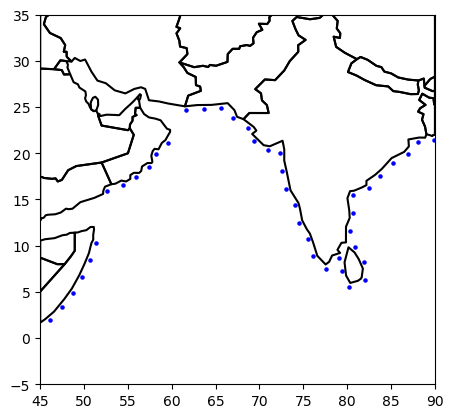

In [16]:
# Find the points in the 100km buffer
def sample_points(buffer_gdf, dist):
    sampled_points = gpd.GeoDataFrame(columns=['geometry'])

    for geom in buffer_gd.geometry:
        boundary = geom.boundary
        length = boundary.length
        num_points = int(length / dist)
        for i in range(num_points):
            fraction = i / num_points

            point = boundary.interpolate(fraction, normalized=True)

            sampled_points.loc[len(sampled_points)] = Point(point)

    return sampled_points

temp = 2
sampled_points_100km = sample_points(buffered_wgs84[0], temp)
lats_bounds = [-5, 35]
lons_bounds = [45, 90]

# Noise Removal
sampled_points_100km = sampled_points_100km[
    (sampled_points_100km.geometry.y >= lats_bounds[0]) &
    (sampled_points_100km.geometry.y <= lats_bounds[1]) &
    (sampled_points_100km.geometry.x >= lons_bounds[0]) &
    (sampled_points_100km.geometry.x <= lons_bounds[1])
]
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y >= 24) & 
                                              (sampled_points_100km.geometry.y < 30) &
                                              (sampled_points_100km.geometry.x > 45) &
                                              (sampled_points_100km.geometry.x <= 57))]
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y >= 11) & 
                                              (sampled_points_100km.geometry.y < 15) &
                                              (sampled_points_100km.geometry.x > 45) &
                                              (sampled_points_100km.geometry.x <= 52))]
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y >= 22) & 
                                              (sampled_points_100km.geometry.y < 27) &
                                              (sampled_points_100km.geometry.x > 55) &
                                              (sampled_points_100km.geometry.x <= 61))]

# reindex
sampled_points_100km = sampled_points_100km.reset_index(drop=True)

fig, ax = plt.subplots()
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])

plt.show()

In [17]:
def get_nearest_points(source_points, candidate_points, lons_bounds, lats_bounds):
    nearest_points = gpd.GeoDataFrame(columns=['geometry'])

    # Only keep candidate_points that are within the bounding box
    candidate_points = candidate_points[
        (candidate_points.geometry.y >= lats_bounds[0]) &
        (candidate_points.geometry.y <= lats_bounds[1]) &
        (candidate_points.geometry.x >= lons_bounds[0]) &
        (candidate_points.geometry.x <= lons_bounds[1])
    ]
    
    for i, source_point in enumerate(source_points.geometry):
        # Compute distances from source_point to all candidate_points
        distances = candidate_points.distance(source_point)

        # Find the index of the nearest point
        nearest_point_index = distances.idxmin()

        nearest_point = candidate_points.loc[nearest_point_index]

        # Append the nearest point to the GeoDataFrame
        nearest_points.loc[i] = nearest_point

    return nearest_points

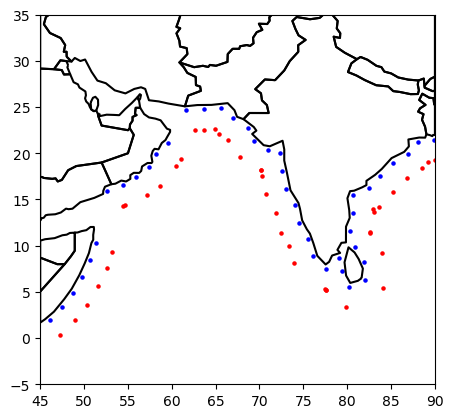

In [18]:
# Get all points on the boundary of the 300km buffer
def generate_points(line, distance):
    total_length = line.length
    distances = np.arange(0, total_length, distance)
    points = [line.interpolate(d) for d in distances]
    return points

all_points_300km = []
for boundary in buffered_wgs84[1].boundary:
    if boundary.geom_type == 'LineString':
        lines = [boundary]
    elif boundary.geom_type == 'MultiLineString':
        lines = boundary
    for line in lines:
        points = generate_points(line, 0.01) # Adjust the distance here
        all_points_300km.extend(points)
all_points_300km_gdf = gpd.GeoDataFrame(gpd.GeoSeries(all_points_300km), columns=['geometry'])

# all_points_300km = [Point(x, y) for line in buffered_wgs84[1].boundary for x, y in line.coords]
# all_points_300km_gdf = gpd.GeoDataFrame(gpd.GeoSeries(all_points_300km), columns=['geometry'])

# Find the nearest points on the 300km buffer for each point on the 100km buffer
nearest_points = get_nearest_points(sampled_points_100km, all_points_300km_gdf,
                                    lons_bounds, lats_bounds)

fig, ax = plt.subplots()
nearest_points.plot(ax=ax, color='red', markersize=5)
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])

plt.show()

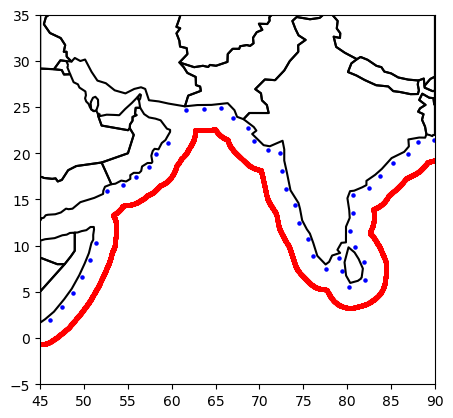

In [19]:
# Visualize the entire set of points on the 300km buffer
fig, ax = plt.subplots()
all_points_300km_gdf.plot(ax=ax, color='red', markersize=5)
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])

plt.show()

In [20]:
def find_nearest_sst(point, tree, df):
    lon, lat = point.x, point.y
    _, idx = tree.query(np.array([lon, lat]), k=1)
    nearest_sst = df.iloc[idx]['sea_surface_temperature']
    return nearest_sst

def get_sst_difference(df, points1, points2, tree):
    sst_diff = []
    for point1, point2 in zip(points1.geometry, points2.geometry):
        sst1 = find_nearest_sst(point1, tree, df)
        sst2 = find_nearest_sst(point2, tree, df)
        sst_diff.append(abs(sst1 - sst2))
    return sst_diff

In [28]:
threshold = 0.15
import pickle
daily_indices = {}
for date, group in grouped:
    coords = group[['lon', 'lat']].values
    tree = cKDTree(coords)
    sst_diff = get_sst_difference(group, sampled_points_100km, nearest_points, tree)
    exceeded_threshold_indices = [i for i, diff in zip(sampled_points_100km.index, sst_diff) if diff > threshold]
    daily_indices[date] = exceeded_threshold_indices

with open('daily_indices.pickle', 'wb') as handle:
    pickle.dump(daily_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('sampled_points_100km.pickle', 'wb') as handle:
    pickle.dump(sampled_points_100km, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# from datetime import datetime
# dates = [datetime.strptime(str(date), '%Y-%m-%d') for date in labels.keys()]
# labels_da = xr.DataArray(list(labels.values()), dims=['time0'], coords={'time0': dates})
# dataset = xr.Dataset({'labels': labels_da})
# dataset.to_netcdf('labels.nc')

In [27]:
def latlon_to_index(lat, lon, lats, lons):
    lat_index = np.abs(lats - lat).argmin()
    lon_index = np.abs(lons - lon).argmin()
    return lat_index, lon_index

In [26]:
point = sampled_points_100km.geometry[0]
lon = point.x
lat = point.y
print(lat)

10.294813025307628
